In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output

In [ ]:
# Load the data
data = pd.read_csv('data.csv')

# Extract the month from the REF_DATE column
data['Month'] = pd.DatetimeIndex(data['REF_DATE']).month

# List of weather columns to transform
weather_cols = ['Temperature', 'Max Temperature', 'Min Temperature', 'Snowfall', 'Precipitation', 'Snow on ground at EOM', '# precipitation days', '# warm days (18C+)']

# Create a dictionary to hold the new columns
new_columns = {}

# Generate the new columns for each weather variable
for weather in weather_cols:
    for m in range(1,12+1):
        month_shift = (data['Month'] - m) % 12
        new_col = [data.loc[i, f'{weather}_{str(-ms)}'] for i, ms in enumerate( month_shift )]
        new_col_name = f'm{weather}_{m}'
        new_columns[new_col_name] = new_col

# Add the new columns to the DataFrame using pd.concat
data = pd.concat([data, pd.DataFrame(new_columns)], axis=1)

# Drop the original columns
for weather in weather_cols:
    for m in range(12):
        col_name = f'{weather}_{str(-m)}'
        if col_name in data.columns:
            data.drop(columns=[col_name], inplace=True)

[-11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0]

In [35]:
data = pd.read_csv('data.csv')

data['Month'] = pd.DatetimeIndex(data['REF_DATE']).month

data = data.drop(['REF_DATE'], axis=1)
data = pd.get_dummies(data, columns=['GEO', 'Category', 'Farm products', 'CattleType', 'Month'], drop_first=False)

y = data.YoY_change_1
X = data.drop(columns=['YoY_change_1'])


first_cat = np.where(X.columns == 'GEO_Alberta')[0][0]
cat_columns = X.columns[first_cat:]
num_columns = X.columns[:first_cat]

interaction_columns = [X]
interaction_names = X.columns.to_list()

for cat in cat_columns:
    for num in num_columns:
        interaction_term = X[cat] * X[num]
        interaction_term_name = f'{cat}_x_{num}'
        interaction_columns.append(interaction_term)
        interaction_names.append(interaction_term_name)

X = pd.concat(interaction_columns, axis=1)
X.columns = interaction_names


print(X.shape, y.shape)

n_test = 12765
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = n_test, shuffle=False)

print(Xtrain.shape,Xtest.shape)

(63826, 6959) (63826,)
(51061, 6959) (12765, 6959)


In [ ]:
alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 100]
Standardize = Pipeline([
    ('scaling', StandardScaler()),
    ('linear_regression', LinearRegression())])
stamina_index = Xtrain.columns.get_loc('YoY_change_0')

fig, axs = plt.subplots(1,2, figsize = (12.5,6))
axs[0].hist(Xtrain.YoY_change_0)


Standardize = Standardize.fit(Xtrain, ytrain)
Xtrain_standard = Standardize[:-1].transform(Xtrain)
axs[1].hist(Xtrain_standard[:,stamina_index])

In [ ]:
all_Standard = Standardize.fit(all_data, ytrain)
all_scores = cross_val_score(all_Standard, all_data, ytrain, cv=10, scoring='neg_mean_squared_error')

print(all_Standard.score(all_data, ytrain))

In [ ]:
StandardizeRidge = Pipeline([
    ('scaling', StandardScaler()),
    ('ridge', Lasso(alpha=.5))])

lasso = StandardizeRidge.fit(Xtrain, ytrain)
all_scores = cross_val_score(lasso, Xtrain, ytrain, cv=10, scoring='neg_mean_squared_error')

print(-np.mean(all_scores))

0.04342055900223086


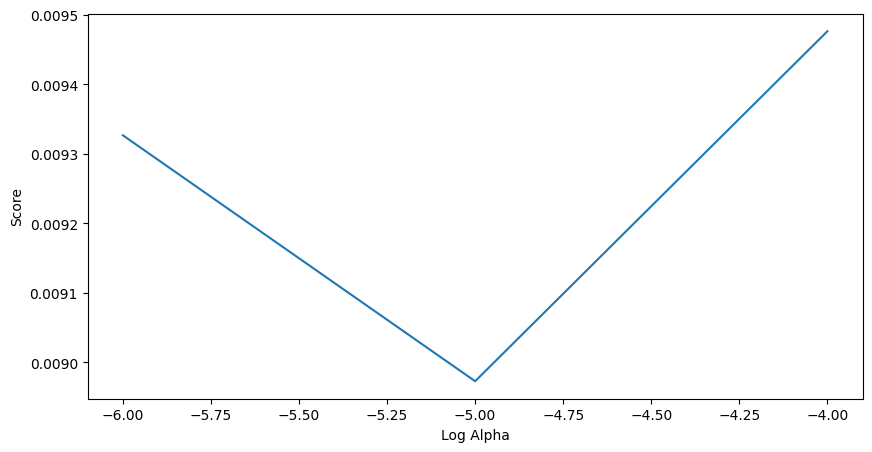

KeyboardInterrupt: 

In [ ]:
alphas = [np.exp(i) for i in range(-6,0)]
scores = []

for i, alpha in enumerate(alphas):
    RidgeModel = Pipeline([('scaling', StandardScaler()), ('ridge_reg', Lasso(alpha = alpha))])
    RidgeModel = RidgeModel.fit(Xtrain, ytrain)
    scores.append(-np.mean(cross_val_score(RidgeModel, Xtrain, ytrain, cv=2, scoring='neg_mean_squared_error')))

    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(np.log(alphas[:(i + 1)]), scores)
    plt.xlabel('Log Alpha')
    plt.ylabel('Score')
    plt.show()


In [ ]:
StandardizeRidge = Pipeline([
    ('scaling', StandardScaler()),
    ('ridge', Lasso(alpha=np.exp(-5)))])

lasso = StandardizeRidge.fit(Xtrain, ytrain)

In [ ]:
beta_indexes = [i for i, x in enumerate(lasso[1].coef_) if x != 0.0]
x = [print(Xtrain.columns[i]) for i in beta_indexes]

YoY_change_-11
YoY_change_-3
YoY_change_-2
YoY_change_0
Category_cattle_x_YoY_change_-4
Category_cattle_x_Diesel_-1
Category_cattle_x_Diesel_0
Category_plant_x_YoY_change_0
